# Massive Data Processing Techniques in Data Science - TDTU

# Giới thiệu

## Thành viên



*   Nguyễn Quốc Anh - 52100871
*   Võ Phú Vinh - 52100947
*   Lục Minh Hiếu - 52100889
*   Nguyễn Vũ Tường - 52100944


# Cài đặt Spark

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
# !cp /content/drive/MyDrive/MMDS/spark-3.1.1-bin-hadoop3.2.tgz /content/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

In [ ]:
import os
import shutil

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

In [ ]:
import findspark
findspark.init()

In [ ]:
# Import Module
from pyspark.sql import SparkSession
from pyspark import SparkContext

import pyspark.sql.types as t
import pyspark.sql.functions as f
import matplotlib.pyplot as plt


In [ ]:
# Turn off future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
sc = SparkContext("local", "App")

In [ ]:
def plot_bar_x_y(x, y, size = (10, 20),
                 x_label='X Label', y_label='Y Label',
                 desc = 'Description', chart_type = 'h'):

    fig, ax = plt.subplots(figsize = size)
    # creating the bar plot
    if chart_type == 'h':
        ax.barh(x, y, height = 0.6, align = 'center')
    elif chart_type == 'v':
        ax.bar(x, y, width = 0.4, align = 'center')
    else:
        raise Exception("Sorry, can not plot chart_type:", chart_type)


    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(desc)

    ax.xaxis.set_tick_params(pad = 5)
    ax.yaxis.set_tick_params(pad = 10)
    for i in ax.patches:
        if chart_type == 'h':
            plt.text(i.get_width(), i.get_y(),
                str(round((i.get_width()), 2)),
                fontsize = 10, fontweight ='bold',
                color ='grey')
        else:
            plt.text(i.get_x(), i.get_height() + 0.5,
                str(round((i.get_height()), 2)),
                fontsize = 10, fontweight ='bold',
                color ='grey')

    plt.show()

# Câu 1: RDD

## F1

In [ ]:
def f1(path: str):
    csv = sc.textFile(path)
    result = csv.flatMap(lambda x: x.split('\n')) \
                        .map(lambda x: x.split(',')) \
                        .filter(lambda x: x[2] != 'itemDescription') \
                        .map(lambda x: x[2]) \
                        .distinct() \
                        .sortBy(lambda x: x)

    if os.path.isdir('f1'):
        shutil.rmtree('f1')

    result.saveAsTextFile('f1')
    list_res = list(result.collect())
    print("First 10 element:", list_res[:10])
    print("Last 10 element:", list_res[-10:])

f1("baskets.csv")

First 10 element: ['Instant food products', 'UHT-milk', 'abrasive cleaner', 'artif. sweetener', 'baby cosmetics', 'bags', 'baking powder', 'bathroom cleaner', 'beef', 'berries']
Last 10 element: ['turkey', 'vinegar', 'waffles', 'whipped/sour cream', 'whisky', 'white bread', 'white wine', 'whole milk', 'yogurt', 'zwieback']


## F2

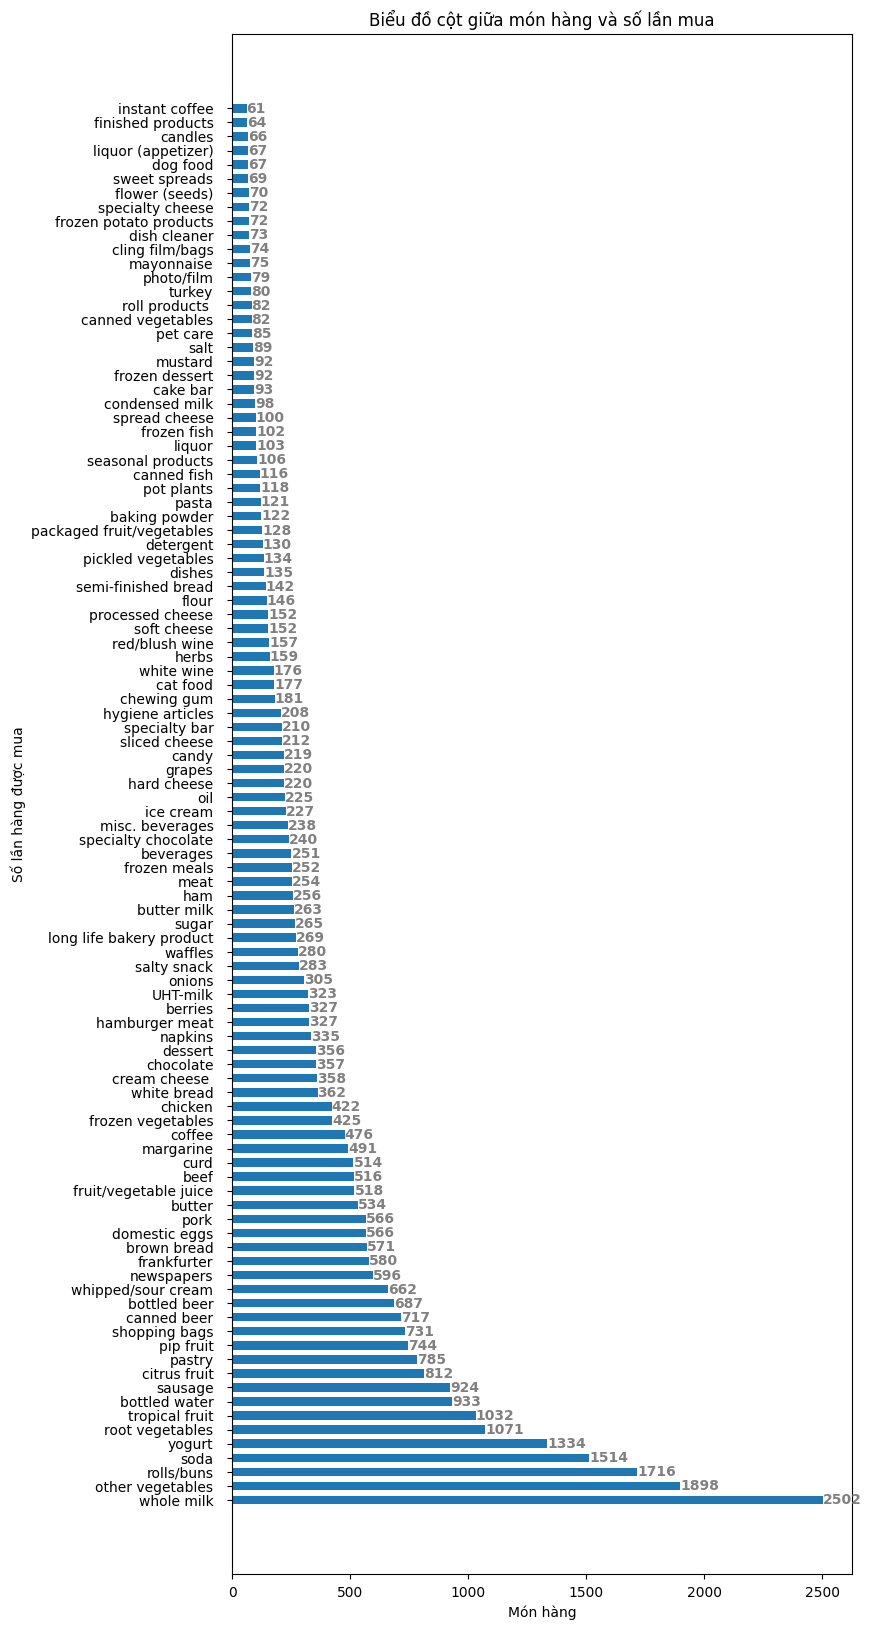

In [ ]:
def f2(path: str):
    csv = sc.textFile(path)
    result = csv.flatMap(lambda x: x.split('\n')) \
                        .map(lambda x: x.split(',')) \
                        .filter(lambda x: x[2] != 'itemDescription') \
                        .map(lambda x: (x[2], 1)) \
                        .reduceByKey(lambda x, y: x + y) \
                        .sortBy(lambda x: x[1], False)
    if os.path.isdir('f2'):
        shutil.rmtree('f2')

    result.saveAsTextFile('f2')
    list_res = list(result.collect())
    top_100_prod = list_res[:100]
    x = [x[0] for x in top_100_prod]
    y = [x[1] for x in top_100_prod]
    plot_bar_x_y(x, y, size = (8, 20), x_label = "Món hàng",
                 y_label = "Số lần hàng được mua",
                 desc = "Biểu đồ cột giữa món hàng và số lần mua",
                 chart_type='h')

f2("baskets.csv")

## F3

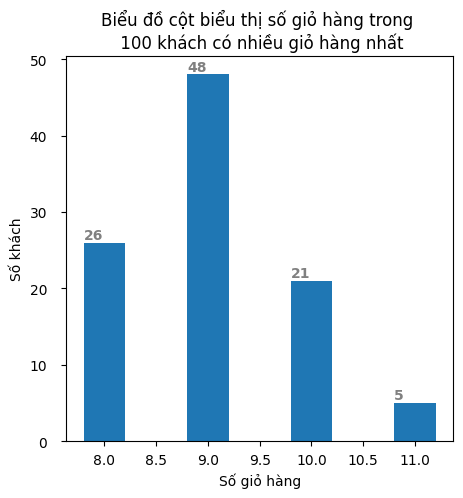

In [ ]:
def f3(path: str):
    csv = sc.textFile(path)
    result = csv.flatMap(lambda x: x.split('\n')) \
                        .map(lambda x: x.split(',')) \
                        .filter(lambda x: x[2] != 'itemDescription') \
                        .groupBy(lambda x: (x[0], x[1])) \
                        .mapValues(lambda x: len(x)) \
                        .groupBy(lambda x: x[0][0]) \
                        .mapValues(lambda x: len(x)) \
                        .sortBy(lambda x: x[1], False)

    if os.path.isdir('f3'):
        shutil.rmtree('f3')

    top_100 = result.take(100)
    result.saveAsTextFile('f3')

    count_basket = dict()

    for i in range(100):
        if top_100[i][1] not in count_basket:
            count_basket[top_100[i][1]] = 0
        count_basket[top_100[i][1]] += 1

    x = list(count_basket.keys())
    y = list(count_basket.values())
    plot_bar_x_y(x, y, (5, 5), x_label = "Số giỏ hàng",
                 y_label = "Số khách",
                 desc = "Biểu đồ cột biểu thị số giỏ hàng trong " +
                 "\n 100 khách có nhiều giỏ hàng nhất",
                 chart_type = 'v')

f3('baskets.csv')

## F4

In [ ]:
def f4(path: str):
    csv = sc.textFile(path)
    result = csv.flatMap(lambda x: x.split('\n')) \
                        .map(lambda x: x.split(',')) \
                        .filter(lambda x: x[2] != 'itemDescription') \
                        .map(lambda x: (x[0], x[2])) \
                        .distinct()

    cus_res = result.groupByKey() \
                    .mapValues(lambda x: len(x)) \
                    .max(key = lambda x: x[1])

    print(f"Khác hàng {cus_res[0]} đã mua nhiều" +
    f" món hàng phân biệt nhất với {cus_res[1]} món hàng.")

    it_res = result.groupBy(lambda x: x[1]) \
                           .mapValues(lambda x: len(x)) \
                           .max(key = lambda x: x[1])

    print("Món hàng được mua bởi nhiều người dùng nhất.",it_res)

    if os.path.isdir('f4'):
        shutil.rmtree('f4')

    sc.parallelize([cus_res, it_res]).saveAsTextFile('f4')

f4('baskets.csv')

Khác hàng 2051 đã mua nhiều món hàng phân biệt nhất với 26 món hàng.
Món hàng được mua bởi nhiều người dùng nhất. ('whole milk', 1786)


# Câu 2: Dataframe

## Tạo SparkSession để dùng Dataframe

In [ ]:
spark = SparkSession.builder \
        .master("local") \
        .appName("Midterm Essay") \
        .getOrCreate()

In [ ]:
path_csv = 'baskets.csv'

customSchema = t.StructType([
    t.StructField("Member_number", t.StringType()),
    t.StructField("Date", t.StringType()),
    t.StructField("itemDescription", t.StringType()),
    t.StructField("year", t.ShortType()),
    t.StructField("month", t.ByteType()),
    t.StructField("day", t.ByteType()),
    t.StructField("day_of_week", t.ByteType()),
])

df = spark.read.csv(path_csv, schema=customSchema, header=True)
df = df.dropDuplicates()

In [ ]:
# Convert Date column to date type
df = df.withColumn("Date",f.to_timestamp(df['Date'], 'dd/MM/yyyy'))

result = df.groupBy("Member_number", "Date") \
  .agg(
      f.concat_ws(
          ",",
          f.collect_set("itemDescription")
      ).alias("basket")
  ) \
  .orderBy("Date")

In [ ]:
if os.path.isdir('baskets'):
    shutil.rmtree('baskets')

result.write.csv('baskets', header = True)

In [ ]:
import matplotlib.dates as mdates

# Convert to Pandas DataFrame for plotting
result = result.withColumn("Date", f.date_format("Date", "yyyy-MM-dd HH:mm:ss"))
basket_per_day_df = result.groupBy("Date").count().orderBy("Date")
basket_per_day_df = basket_per_day_df.toPandas()

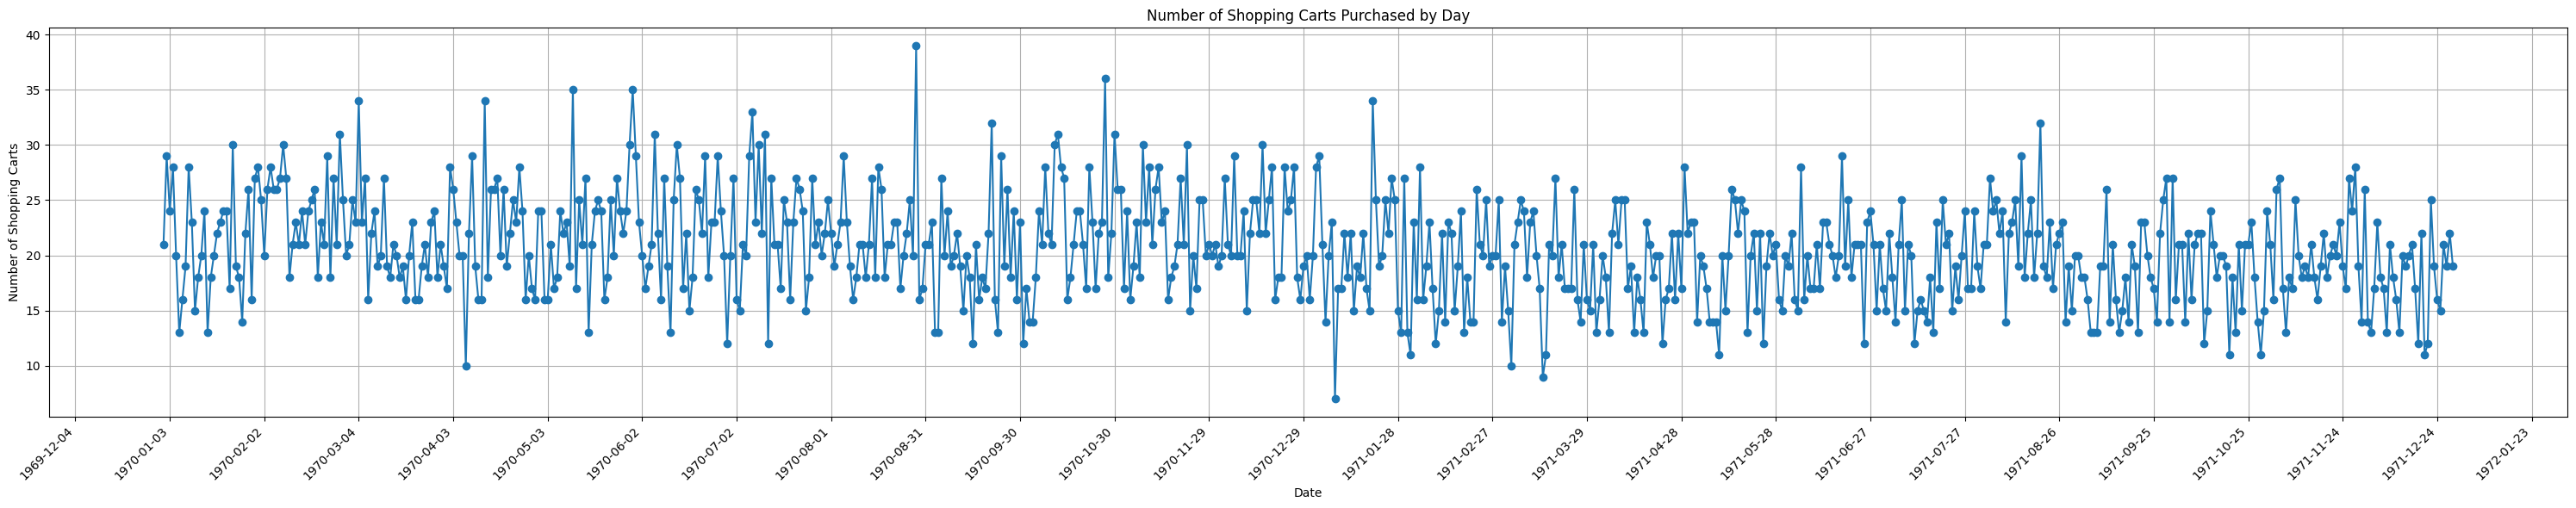

In [ ]:
# Plotting
plt.figure(figsize=(30, 6))
plt.plot(basket_per_day_df["Date"], basket_per_day_df["count"], marker='o', linestyle='-')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30))
plt.gcf().autofmt_xdate()
plt.title("Number of Shopping Carts Purchased by Day")
plt.xlabel("Date")
plt.ylabel("Number of Shopping Carts")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Câu 3: PCY

In [ ]:
from pyspark.sql.session import SparkSession
from pyspark.sql import functions as f
from pyspark.sql import types as t
from itertools import combinations


class PCY():
    def __init__(self, path: str, s: float = 0.3, c: float = 0.5):
        self.path = path
        self.s = s
        self.c = c
        self.spark = SparkSession.builder \
                                 .master("local") \
                                 .appName("App") \
                                 .getOrCreate()

    def __read_csv(self):
        files = os.listdir(self.path)
        customSchema = t.StructType([
            t.StructField("Member_number", t.StringType()),
            t.StructField("Date", t.DateType()),
            t.StructField("basket", t.StringType())
        ])
        csv_files = [self.path + "/" +
                     file for file in files if file.endswith('.csv')]
        # df = self.spark.read.csv(csv_files, schema=customSchema, header=True)
        df = self.spark.read.option("header", "true").csv(self.path, schema=customSchema)
        df = df.withColumn("basket", f.split('basket',"[,]"))

        return df

    @staticmethod
    def __hash(i, j):
        s = 0

        for c in i:
            s = (s * 51 + ord(c)) % 200
        for c in j:
            s = (s * 51 + ord(c)) % 200

        return s

    def __run_step_1(self):
        all_items = self.df.select(f.explode("basket").alias("item"))
        min_sp_thres = self.df.count() * self.s
        # Pass 1
        # Find freq items with support > support threshold
        temp = all_items \
            .groupBy("item").count() \
            .filter(f.col("count") > min_sp_thres) \
            .collect()

        self.freq_single_items = dict()

        for i in temp:
            self.freq_single_items[i['item']] = i['count']

        generate_combinations_udf = f.udf(lambda x: list(combinations(sorted(x), 2)),
                                          t.ArrayType(t.ArrayType(t.StringType())))

        generate_hash_udf = f.udf(lambda x: [PCY.__hash(i[0], i[1]) for i in x],
                                  t.ArrayType(t.ByteType()))

        # Find generate combination of pair and hash them to the bucket
        hashed_basket = self.df \
            .withColumn("basket", generate_combinations_udf("basket")) \
            .withColumn("hashed", generate_hash_udf("basket"))
        print("1")
        hashed_basket.show(5, truncate = False)

        # Basket                        Hashed
        # [(a, b), (a, c), (b, c)]      [1, 2, 3]

        # Bucket    Hashed
        # (a, b)    1
        # (a, c)    2
        # (b, c)    3
        # (d, c)    3

        self.freqItemsets = hashed_basket \
            .select(
                f.explode(
                    f.arrays_zip(
                        hashed_basket['basket'],
                        hashed_basket['hashed']
                    )
                )
                .alias("exploded")
            ) \
            .selectExpr(
                "CAST(exploded['hashed'] AS BYTE) AS Hashed",
                "exploded['basket'] AS Basket"
            ) \
            .groupBy("Hashed") \
            .agg(f.collect_list("Basket").alias("basket"))
        print("2")
        self.freqItemsets.show(5, truncate = False)

        # Filter the bucket that meet the requirement
        # If the bucket is not frequent
        # -> items in the bucket is not freq
        self.freqItemsets = self.freqItemsets \
            .withColumn("count", f.size("basket")) \
            .filter(f.col("count") > min_sp_thres) \
            .select(f.explode('basket').alias('items')) \
            .withColumn("item1", f.udf(lambda x: x[0], t.StringType())('items')) \
            .withColumn("item2", f.udf(lambda x: x[1], t.StringType())('items'))

        print("Done pass 1")
        self.freqItemsets.show(5, truncate = False)

        # Pass 2
        self.freqItemsets = self.freqItemsets \
            .filter(f.col("item1").isin(list(self.freq_single_items.keys()))) \
            .filter(f.col("item2").isin(list(self.freq_single_items.keys()))) \
            .groupBy("items") \
            .count() \
            .filter(f.col('count') > min_sp_thres)

        print("Done pass 2")
        self.freqItemsets.show(5, truncate = False)

    def __run_step_2(self):
        # Create DF to join the table for calculate
        customSchema = t.StructType([
            t.StructField("item", t.StringType()),
            t.StructField("count", t.IntegerType())
        ])
        freq_item_df = self.spark.createDataFrame(
            list(map(list, self.freq_single_items.items())),
            schema = customSchema
        ).cache()

        split_and_reverse_udf = f.udf(
            lambda x: [[x[0], x[1]], [x[1], x[0]]],
            t.ArrayType(t.ArrayType(t.StringType()))
        )
        generate_antecedent_udf = f.udf(lambda x: x[0], t.StringType())
        generate_consequent_udf = f.udf(lambda x: x[1], t.StringType())
        # Each pair (x[0], x[1]) has 2 accsociation rules
        # x[0] -> x[1]
        # x[1] -> x[2]
        # Convert list [x[0], x[1]] to
        # [[x[0], x[1]], [x[1], x[0]]]
        # Then explode them to create antecedent and consequent
        self.associationRules = self.freqItemsets \
            .withColumn("temp", split_and_reverse_udf('items')) \
            .select('count', 'temp') \
            .withColumn("exploded", f.explode('temp')) \
            .select('exploded', 'count') \
            .withColumn('antecedent', generate_antecedent_udf('exploded')) \
            .withColumn('consequent', generate_consequent_udf('exploded')) \
            .select('antecedent', 'consequent', 'count') \
            .cache()

        print("1")
        self.associationRules.show(5, truncate = False)

        # Calculate confidence, lift and support
        # lift: double: A measure of how well the antecedent predicts the consequent,
        # calculated as support(antecedent U consequent) / (support(antecedent) x support(consequent))
        # (count(antecedent U consequent) / df.count) / ((count(antecedent) / df.count) x (count(consequent) / df.count))
        # (count(antecedent U consequent)*df.count)/(count(antecedent) x count(consequent))
        self.associationRules = self.associationRules.alias('df1') \
            .join(
                freq_item_df.alias('df2'),
                f.col('df1.antecedent') == f.col('df2.item')) \
            .join(
                freq_item_df.alias('df3'),
                f.col('df1.consequent') == f.col('df3.item')) \
            .withColumn(
                'confidence',
                f.col('df1.count') / f.col('df2.count')) \
            .withColumn(
                'lift',
                f.col('confidence') / (f.col('df3.count') / self.df.count())) \
            .withColumn(
                'support',
                f.col('df1.count') / self.df.count()) \
            .select('antecedent', 'consequent', 'confidence', 'lift', 'support') \
            .filter(f.col('confidence') > self.c)
        print('2')
        self.associationRules.show(5, truncate = False)

    def run(self):
        self.df = self.__read_csv()
        self.__run_step_1()
        self.freqItemsets \
            .toPandas() \
            .to_csv("pcy_frequent_pairs.csv", index=False)
        self.__run_step_2()
        self.associationRules \
            .toPandas() \
            .to_csv("pcy_association_rules.csv", index=False)


In [ ]:
pcy = PCY("baskets", 0.01, 0.05)
%time pcy.run()

1
+-------------+----------+--------------------------------------------------------------------------+----------------+
|Member_number|Date      |basket                                                                    |hashed          |
+-------------+----------+--------------------------------------------------------------------------+----------------+
|1206         |2015-02-01|[[cat food, sausage]]                                                     |[63]            |
|4933         |2015-02-01|[[bottled water, sausage]]                                                |[-82]           |
|3682         |2015-02-01|[[citrus fruit, shopping bags]]                                           |[69]            |
|2271         |2015-02-01|[[mayonnaise, rolls/buns]]                                                |[-87]           |
|3754         |2015-02-01|[[margarine, pip fruit], [margarine, whole milk], [pip fruit, whole milk]]|[-91, -102, 119]|
+-------------+----------+--------------------

In [ ]:
sc.stop()